In [1]:
import re

import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd

%matplotlib inline

plt.style.use("seaborn-v0_8")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%bash
ls -lh ../data/raw

total 3.4M
-rw-r--r-- 1 root root  159 Jul 12 11:43 prompts_test.csv
-rw-r--r-- 1 root root  16K Jul 12 11:43 prompts_train.csv
-rw-r--r-- 1 root root  111 Jul 12 11:43 sample_submission.csv
-rw-r--r-- 1 root root  166 Jul 12 11:43 summaries_test.csv
-rw-r--r-- 1 root root 3.3M Jul 12 11:43 summaries_train.csv


In [3]:
prompts_train = pd.read_csv('../data/raw/prompts_train.csv')
prompts_test = pd.read_csv('../data/raw/prompts_test.csv')
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')
summaries_train = pd.read_csv('../data/raw/summaries_train.csv')
summaries_test = pd.read_csv('../data/raw/summaries_test.csv')

In [4]:
display(prompts_train.head())
display(prompts_train.info())

display(summaries_train.head())
display(summaries_train.info())

display(sample_submission.head())

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


None

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


None

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [5]:
prompts_train['prompt_id'].nunique(), prompts_test['prompt_id'].nunique()

(4, 2)

In [6]:
# NOTE: train と test の prompt_id は重複していない
len(set(prompts_train['prompt_id'].unique().tolist()) | set(prompts_test['prompt_id'].unique().tolist()))

6

In [7]:
summaries_train['student_id'].nunique(), summaries_test['student_id'].nunique()

(7165, 4)

In [8]:
# NOTE: train と test の student_id は重複していない
len(set(summaries_train['student_id'].unique().tolist()) | set(summaries_test['student_id'].unique().tolist()))

7169

いずれもidは重複していないので、cvはKFoldで分割する。

## Missing Values

<Axes: >

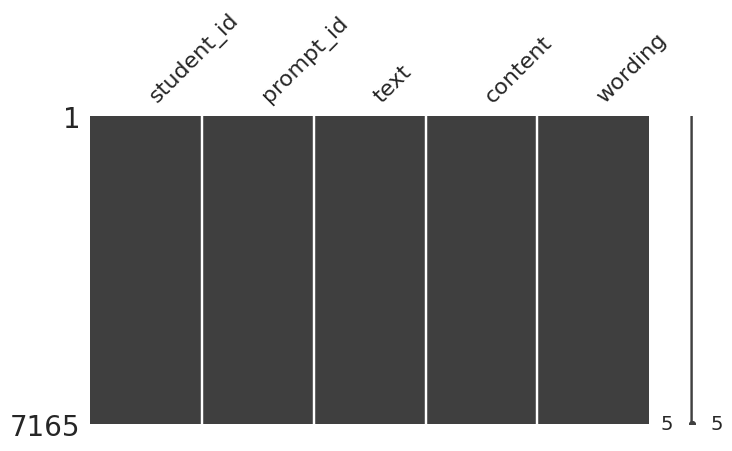

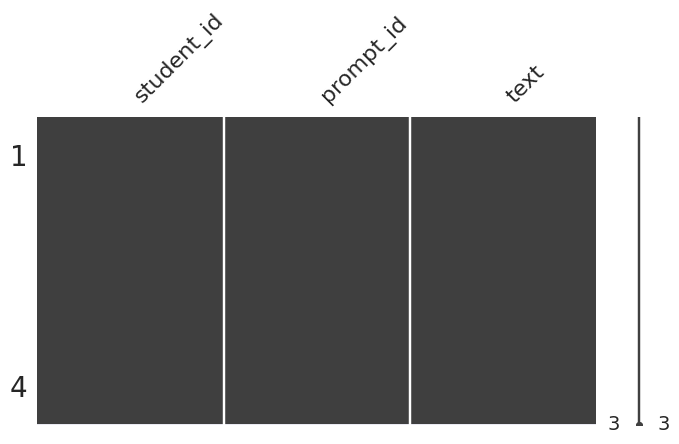

In [9]:
msno.matrix(summaries_train, figsize=(8, 4))
msno.matrix(summaries_test, figsize=(8, 4))

## Target Distribution

<Axes: >

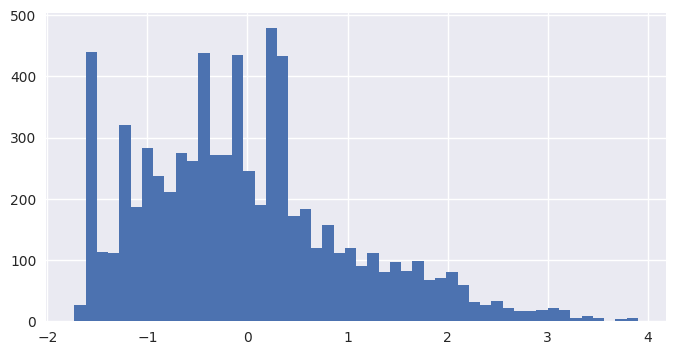

In [10]:
summaries_train["content"].hist(bins=50, figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: content, dtype: object

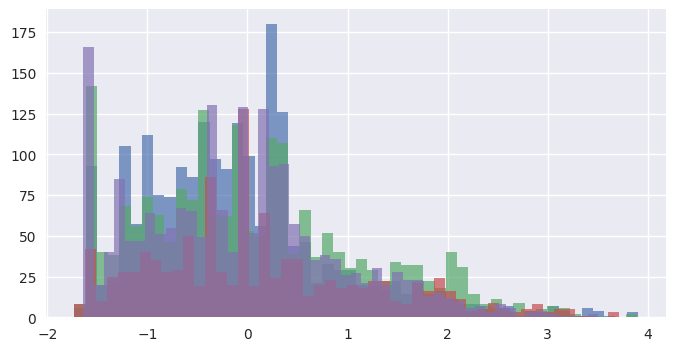

In [11]:
summaries_train.groupby("prompt_id")["content"].hist(bins=50, figsize=(8, 4), alpha=0.7)

<Axes: >

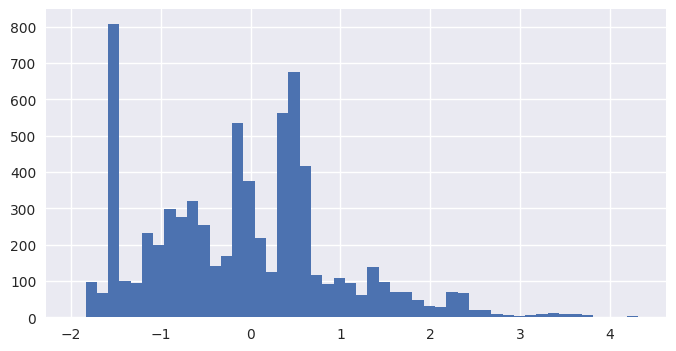

In [12]:
summaries_train["wording"].hist(bins=50, figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: wording, dtype: object

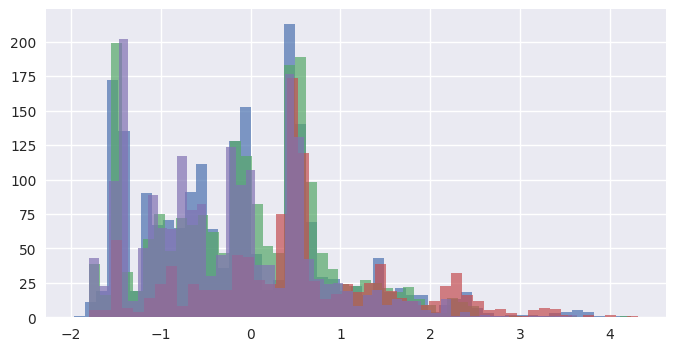

In [13]:
summaries_train.groupby("prompt_id")["wording"].hist(bins=50, figsize=(8, 4), alpha=0.7)

<Axes: xlabel='content', ylabel='wording'>

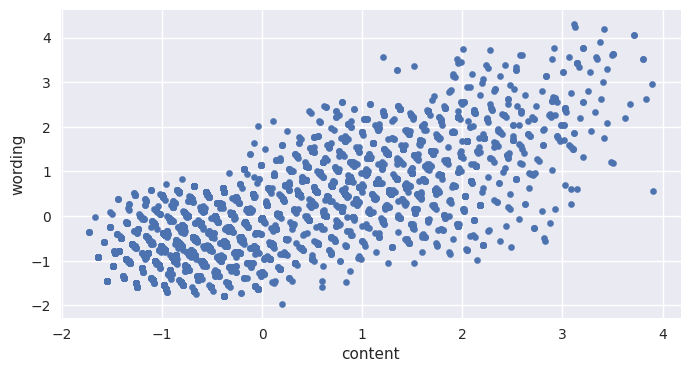

In [14]:
summaries_train.plot.scatter(x="content", y="wording", figsize=(8, 4))

## Text Features

In [15]:
summaries_train = summaries_train.assign(
    text_length=summaries_train["text"].str.len(),
    word_count=summaries_train["text"].str.split().str.len(),
    word_unique_count=summaries_train["text"].str.split().apply(set).str.len(),
    sentence_count=summaries_train["text"].str.split(".").str.len(),
    quoted_sentence_count=summaries_train["text"].apply(lambda x: len(re.findall(r'"(.*?)"', str(x)))),
    triple_dots_count=summaries_train["text"].apply(lambda x: len(re.findall(r"\.{3,4}", str(x)))),
)

In [16]:
def plot_feature(col: str = "text_length", bins: int = 50):
    summaries_train[col].hist(bins=50, figsize=(8, 4))
    summaries_train.plot.scatter(x="content", y=col, figsize=(8, 4))
    summaries_train.plot.scatter(x="wording", y=col, figsize=(8, 4))

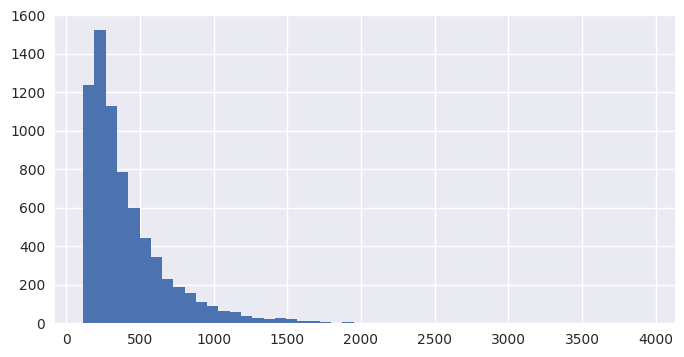

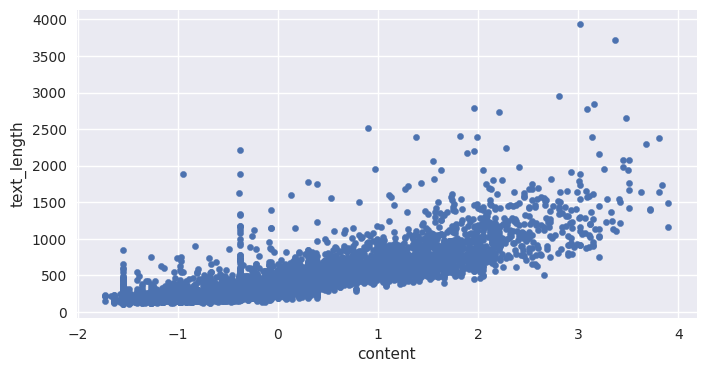

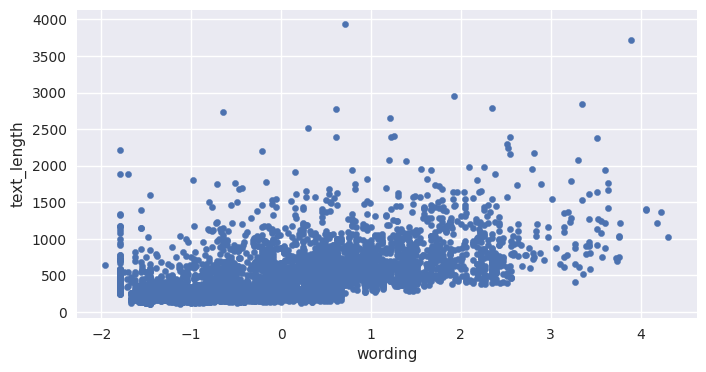

In [17]:
plot_feature("text_length")

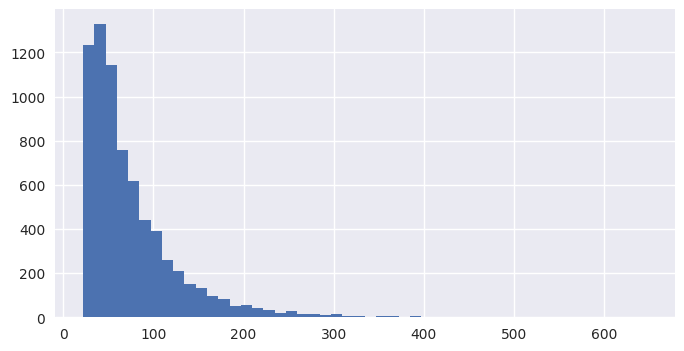

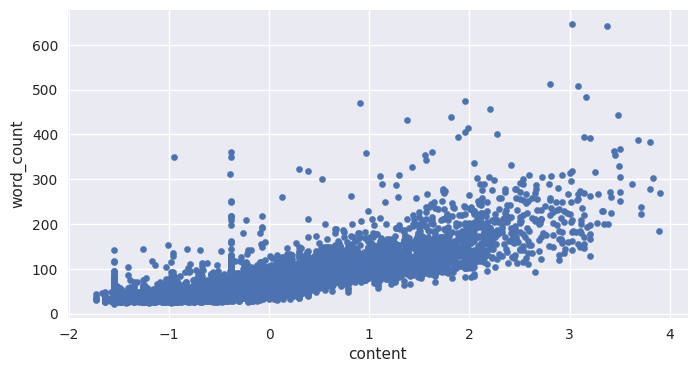

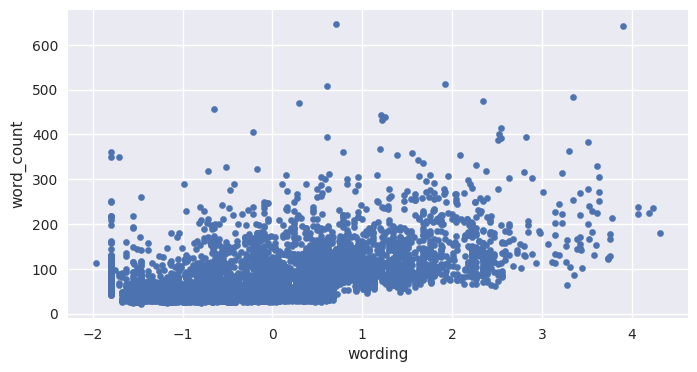

In [18]:
plot_feature("word_count")

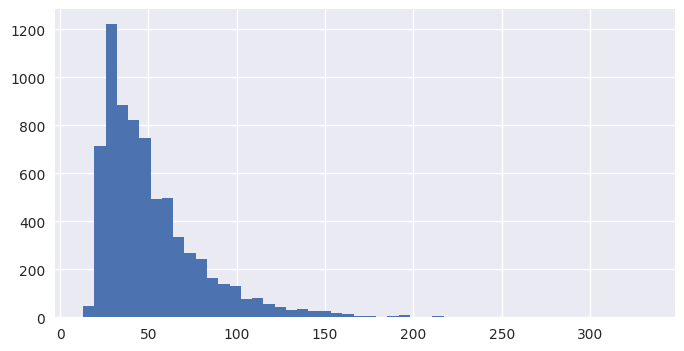

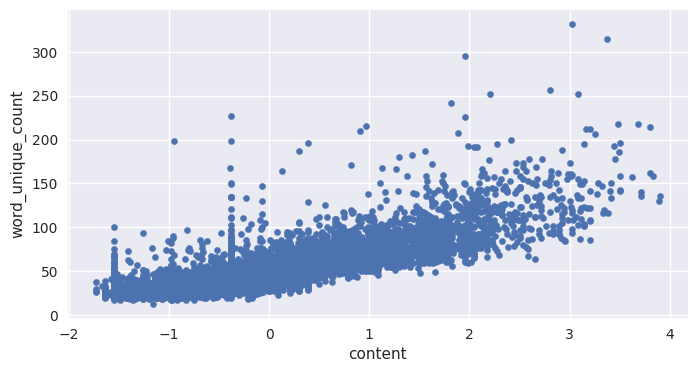

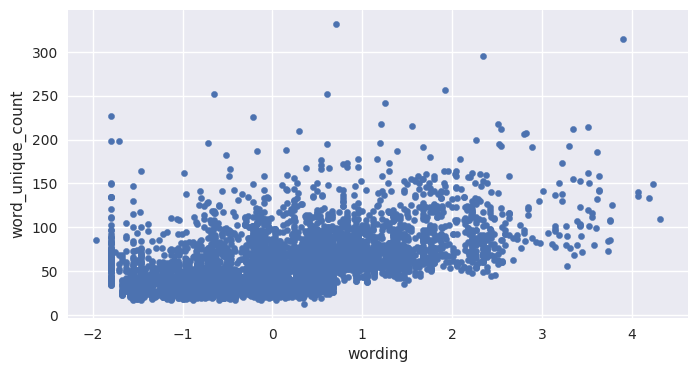

In [19]:
plot_feature("word_unique_count")

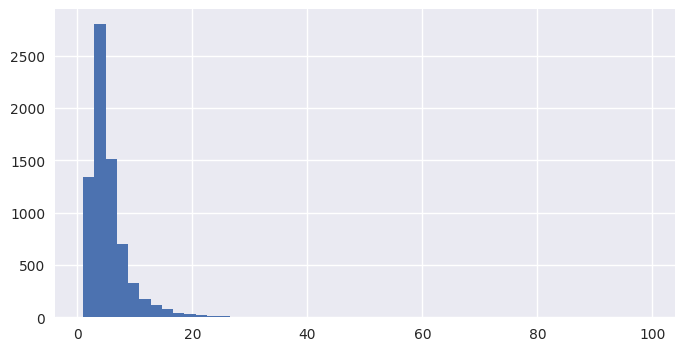

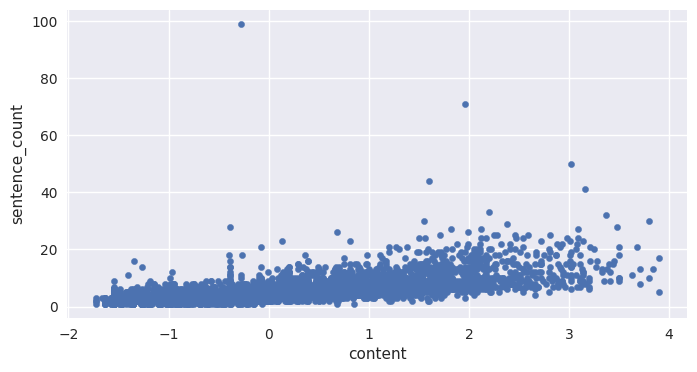

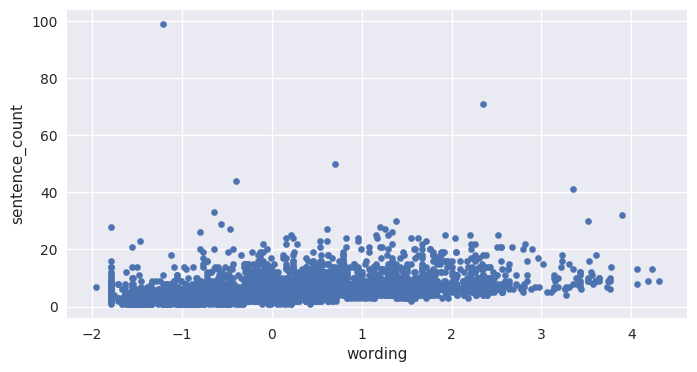

In [20]:
plot_feature("sentence_count")

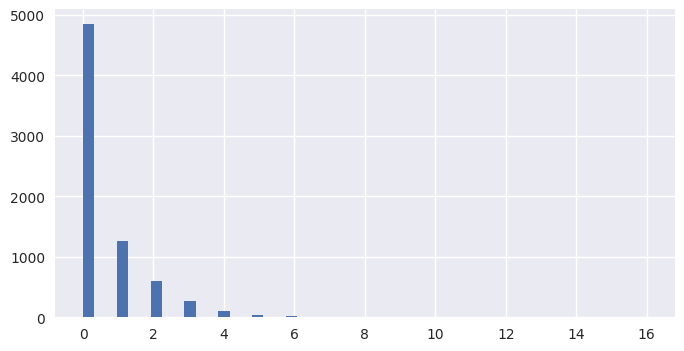

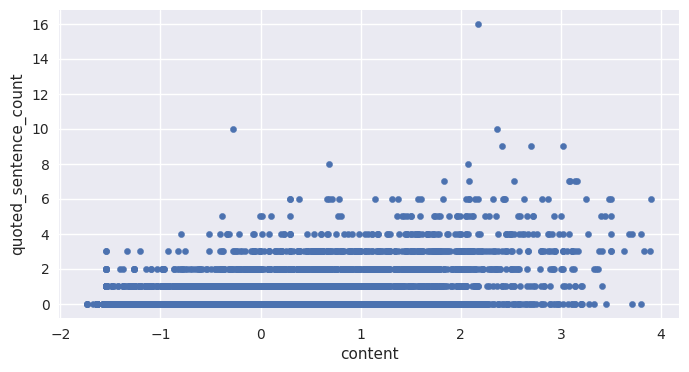

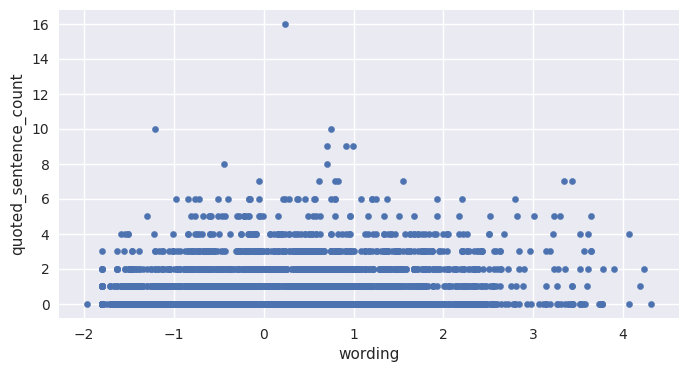

In [21]:
plot_feature("quoted_sentence_count")

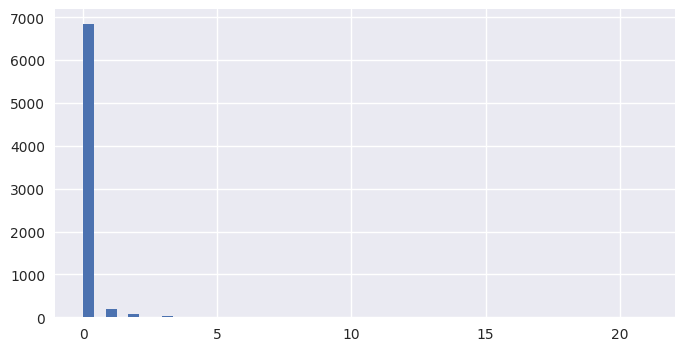

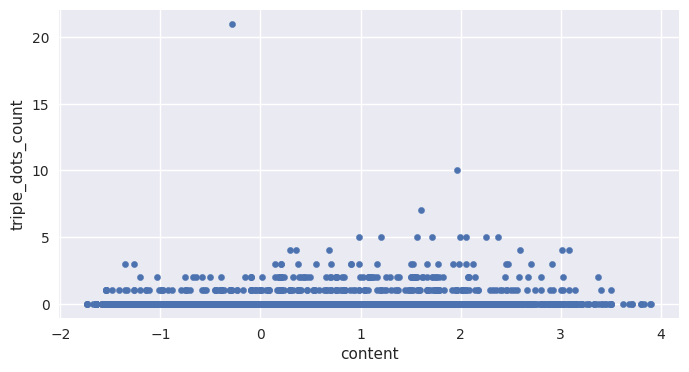

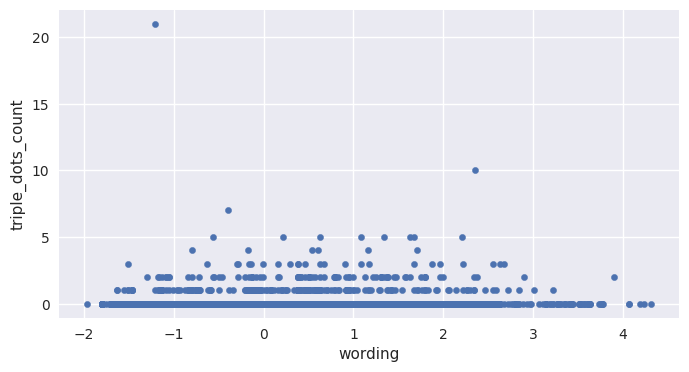

In [22]:
plot_feature("triple_dots_count")

textの前処理で気を付けたいやつ

- " で囲まれている文章の有無
  - 文章数のカウントで過増に読んでしまう

In [23]:
for row in summaries_train.sample(10).iterrows():
    print(row[1]["text"])
    print("-" * 100)

It developed so quickly becaus eeveryone was just following the crowd. They saw all the kids from Mr.Jones class doing the salute outside the classroom  making them curious what they were doing so they followed the crowd and ended up joing their "movement". The expirement ended because things were getting out of control. What was only suppose to be an exiperment turned into a an actually movement that kids were loyal and  devoted to. So Mr. Jones put an end to things showing them how easy it is t get others to follow a crowd without even knowing or questioning if its intentions were good or bad .
----------------------------------------------------------------------------------------------------
Three elements of an Ideal tragedy would be that it is arranged on a complex plan, it has a plot that sticks to the main idea, and that goes from good to bad, and lastly, it should induce fear and pity.
--------------------------------------------------------------------------------------------